# Predviđanje uspjeha bankarskog marketinga

### Davorin Gradečak, Petra Jambriško, Jakov Krunić

lipanj 2020.


## Uređivanje podataka

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn.preprocessing as preprocessing

%matplotlib inline

In [2]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
train = pd.read_csv('bank-additional-full.csv', sep=';')
test = pd.read_csv('bank-additional.csv', sep=';')

In [4]:
train.shape

(41188, 21)

In [5]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Binarni klasifikator zahtijeva numeričke vrijednosti tako da ćemo vrijednosti tog atributa promijeniti. Preslikavamo 'no' u 0, a 'yes' u 1.

In [6]:
map = {'no' : 0, 'yes' : 1}
train = train.replace({'y' : map})
test = test.replace({'y' : map})

Uočavamo da nigdje nema nedostajućih vrijednosti. 

Zatim uklanjamo podatke koji su duplicirani.

In [7]:
train = train.drop_duplicates()
train.shape

(41176, 21)

Dakle izbacili smo 12 nepotrebnih redaka.

## One Hot Encoding

Da bismo mogli primjenjivati modele strojnog učenja na podatke, moramo napraviti takozvani 'encoding' kategorijskih varijabli. Koristit ćemo One Hot Encoding.

In [8]:
from sklearn.preprocessing import OneHotEncoder
train2 = train[['job','marital','education','default','housing',
                   'loan','contact','month','day_of_week','poutcome']]
test2 = test[['job','marital','education','default','housing',
                   'loan','contact','month','day_of_week','poutcome']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_ohe = ohe.fit_transform(train2)
np.size(train_ohe,1)

53

In [9]:
test_ohe = ohe.fit_transform(test2)
np.size(test_ohe,1)

53

In [10]:
train3 = train.drop('y',axis=1)
train3 = train3[['age','duration','campaign','pdays','previous','emp.var.rate',
                'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]
test3 = test.drop('y',axis=1)
test3 = test3[['age','duration','campaign','pdays','previous','emp.var.rate',
                'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]

In [11]:
for i in range(0,53):
    columni="column"+str(i)
    train3[columni] = train_ohe[:,i]
    test3[columni] = test_ohe[:,i]
    
train3.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,column43,column44,column45,column46,column47,column48,column49,column50,column51,column52
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
test3.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,column43,column44,column45,column46,column47,column48,column49,column50,column51,column52
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
train_x = train3.iloc[:, :-1]
print("Shape of X train:", train_x.shape)
train_y = train['y']
print("Shape of Y train:", train_y.shape)
test_x = test3.iloc[:, :-1]
print("Shape of X test:", test_x.shape)
test_y = test['y']
print("Shape of Y test:", test_y.shape)

Shape of X train: (41176, 62)
Shape of Y train: (41176,)
Shape of X test: (4119, 62)
Shape of Y test: (4119,)


## Logistička regresija

In [14]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(train_x,train_y)
pred_y = model.predict_proba(test_x)

accuracy_test = model.score(test_x,test_y) 

print("Accuracy: ", accuracy_test)
print("AUC score with duration column: ", roc_auc_score(test_y, pred_y[:,1]))

Accuracy:  0.9123573682932751
AUC score with duration column:  0.9327001429030847


In [15]:
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
def display_summary(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    print('confusion matrix')
    print(np.array([[tp,fp],[fn,tn]]))
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))

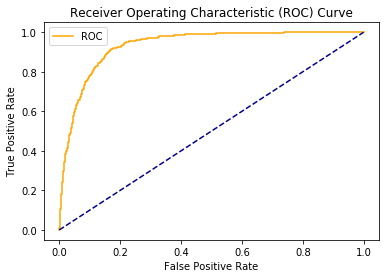

[[3571   97]
 [ 264  187]]
              precision    recall  f1-score   support

           0     0.9312    0.9736    0.9519      3668
           1     0.6585    0.4146    0.5088       451

    accuracy                         0.9124      4119
   macro avg     0.7948    0.6941    0.7304      4119
weighted avg     0.9013    0.9124    0.9034      4119



In [16]:
pred = model.predict(test_x)

y_pred_logistic = pred

fpr, tpr, thresholds = roc_curve(test_y, pred_y[:,1])
plot_roc_curve(fpr, tpr)
print(confusion_matrix(test_y,pred))
print(classification_report(test_y,pred,digits=4))

In [17]:
precision, recall, thresholds = precision_recall_curve(test_y, pred_y[:,1])

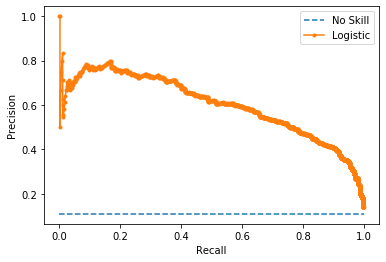

In [18]:
no_skill = len(test_y[test_y==1]) / len(test_y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [19]:
auprc=auc(recall, precision)
auprc

0.6024145058198975

## Naivni Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

modelNB = GaussianNB()
modelNB.fit(train_x,train_y)
pred_y_NB = modelNB.predict_proba(test_x)

accuracy_test = modelNB.score(test_x,test_y)

print("Accuracy: ", accuracy_test)
print("AUC score with duration column: ", roc_auc_score(test_y, pred_y_NB[:,1]))

Accuracy:  0.8548191308570041
AUC score with duration column:  0.8241219076957301


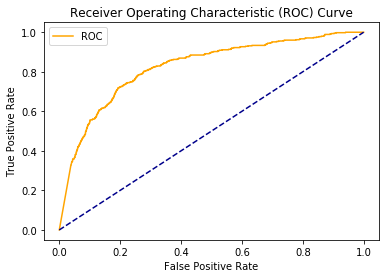

[[3269  399]
 [ 199  252]]
              precision    recall  f1-score   support

           0     0.9426    0.8912    0.9162      3668
           1     0.3871    0.5588    0.4574       451

    accuracy                         0.8548      4119
   macro avg     0.6649    0.7250    0.6868      4119
weighted avg     0.8818    0.8548    0.8660      4119



In [21]:
pred_NB = modelNB.predict(test_x)

fpr, tpr, thresholds = roc_curve(test_y, pred_y_NB[:,1])
plot_roc_curve(fpr, tpr)
print(confusion_matrix(test_y,pred_NB))
print(classification_report(test_y,pred_NB,digits=4))

In [22]:
precision, recall, thresholds = precision_recall_curve(test_y, pred_y_NB[:,1])

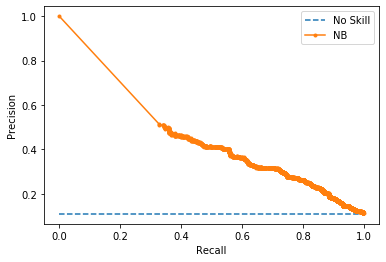

0.4638142635179989


In [23]:
no_skill = len(test_y[test_y==1]) / len(test_y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='NB')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

auprc=auc(recall, precision)

print(auprc)

## SVM

In [23]:
from sklearn import svm

features_names = train_x.columns
svm = svm.SVC(kernel='linear',probability=True)
svm.fit(train_x, train_y)
pred_y = svm.predict_proba(test_x)


Accuracy Of SVM For The Given Dataset :  0.8812818645302258


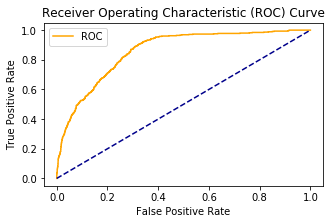

[[3434  234]
 [ 255  196]]
              precision    recall  f1-score   support

           0     0.9309    0.9362    0.9335      3668
           1     0.4558    0.4346    0.4449       451

    accuracy                         0.8813      4119
   macro avg     0.6933    0.6854    0.6892      4119
weighted avg     0.8789    0.8813    0.8800      4119



In [24]:
y_pred_lin = svm.predict(test_x)

accuracy_test = svm.score(test_x,test_y)
print("\nAccuracy Of SVM For The Given Dataset : ", accuracy_test)

fpr, tpr, thresholds = roc_curve(test_y, pred_y[:,1])
plt.rcParams["figure.figsize"] = (5,3)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(test_y,y_pred_lin))
print(classification_report(test_y,y_pred_lin,digits=4))

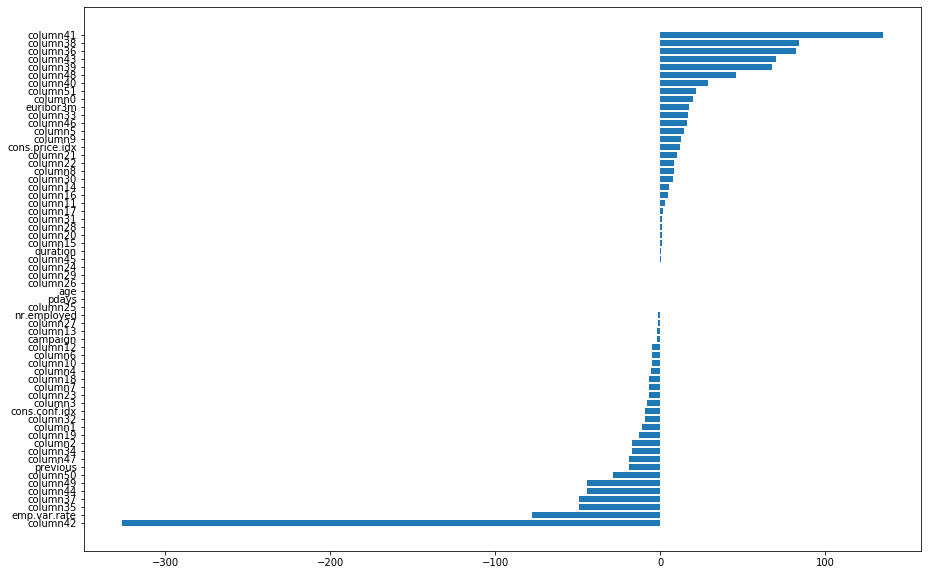

In [25]:
def f_importances_2(coef, names):
    imp = coef[0]
    imp,names = zip(*sorted(zip(imp,names)))
    plt.rcParams["figure.figsize"] = (15,10)
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

f_importances_2(svm.coef_, features_names)

In [26]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
pre1 = precision_score(test_y, y_pred_lin)
rec1 = recall_score(test_y, y_pred_lin)
acc1 = accuracy_score(test_y, y_pred_lin)
f1_1 = f1_score(test_y, y_pred_lin)
print('precision on the evaluation set: ', pre1)
print('recall on the evaluation set: ', rec1)
print('accuracy on the evaluation set: ', acc1)

precision on the evaluation set:  0.4558139534883721
recall on the evaluation set:  0.43458980044345896
accuracy on the evaluation set:  0.8812818645302258


In [27]:
precision, recall, thresholds = precision_recall_curve(test_y, pred_y[:,1])

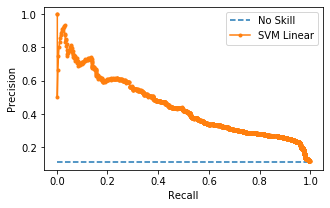

In [28]:
no_skill = len(test_y[test_y==1]) / len(test_y)
plt.rcParams["figure.figsize"] = (5,3)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='SVM Linear')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [29]:
auprc1=auc(recall, precision)
auprc1

0.44884751764839503

In [30]:
from sklearn.svm import SVC

modelSVM = SVC(probability=True)
modelSVM.fit(train_x, train_y)
SVM_pred_y = modelSVM.predict_proba(test_x)


Accuracy Of SVM For The Given Dataset :  0.9009468317552805


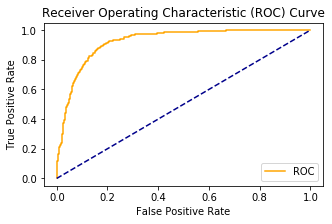

[[3607   61]
 [ 347  104]]
              precision    recall  f1-score   support

           0     0.9122    0.9834    0.9465      3668
           1     0.6303    0.2306    0.3377       451

    accuracy                         0.9009      4119
   macro avg     0.7713    0.6070    0.6421      4119
weighted avg     0.8814    0.9009    0.8798      4119



In [31]:
y_pred_SVM = modelSVM.predict(test_x)

accuracy_test = modelSVM.score(test_x,test_y)
print("\nAccuracy Of SVM For The Given Dataset : ", accuracy_test)

fpr, tpr, thresholds = roc_curve(test_y, SVM_pred_y[:,1])
plt.rcParams["figure.figsize"] = (5,3)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(test_y,y_pred_SVM))
print(classification_report(test_y,y_pred_SVM,digits=4))

In [32]:
pre2 = precision_score(test_y, y_pred_SVM)
rec2 = recall_score(test_y, y_pred_SVM)
acc2 = accuracy_score(test_y, y_pred_SVM)
f1_2 = f1_score(test_y, y_pred_SVM)
print('precision on the evaluation set: ', pre2)
print('recall on the evaluation set: ', rec2)
print('accuracy on the evaluation set: ', acc2)

precision on the evaluation set:  0.6303030303030303
recall on the evaluation set:  0.23059866962305986
accuracy on the evaluation set:  0.9009468317552805


In [33]:
precision, recall, thresholds = precision_recall_curve(test_y, SVM_pred_y[:,1])

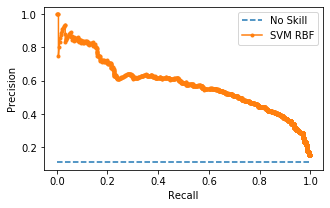

In [34]:
no_skill = len(test_y[test_y==1]) / len(test_y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='SVM RBF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [35]:
auprc2=auc(recall, precision)
auprc2

0.5821636835088713

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=31)
x_pca = pca.fit_transform(train_x)
print(x_pca.shape)

x_pca_test = pca.fit_transform(test_x)
print(x_pca_test.shape)

(41176, 31)
(4119, 31)


In [37]:
modelSVC_PCA = SVC(probability=True)
modelSVC_PCA.fit(x_pca,train_y)
PCA_pred_y = modelSVC_PCA.predict_proba(x_pca_test)


Accuracy Of SVM_PCA For The Given Dataset :  0.9142995872784656


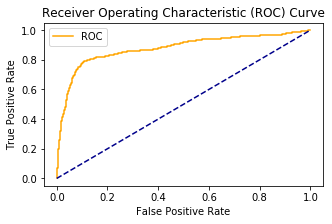

[[3562  106]
 [ 247  204]]
              precision    recall  f1-score   support

           0     0.9352    0.9711    0.9528      3668
           1     0.6581    0.4523    0.5361       451

    accuracy                         0.9143      4119
   macro avg     0.7966    0.7117    0.7445      4119
weighted avg     0.9048    0.9143    0.9072      4119



In [38]:
y_pred_PCA = modelSVC_PCA.predict(x_pca_test)

accuracy_test = modelSVC_PCA.score(x_pca_test,test_y)
print("\nAccuracy Of SVM_PCA For The Given Dataset : ", accuracy_test)

fpr, tpr, thresholds = roc_curve(test_y, PCA_pred_y[:,1])
plot_roc_curve(fpr, tpr)
print(confusion_matrix(test_y,y_pred_PCA))
print(classification_report(test_y,y_pred_PCA,digits=4))

In [39]:
pre3 = precision_score(test_y, y_pred_PCA)
rec3 = recall_score(test_y, y_pred_PCA)
acc3 = accuracy_score(test_y, y_pred_PCA)
f1_3 = f1_score(test_y, y_pred_PCA)
print('precision on the evaluation set: ', pre3)
print('recall on the evaluation set: ', rec3)
print('accuracy on the evaluation set: ', acc3)

precision on the evaluation set:  0.6580645161290323
recall on the evaluation set:  0.4523281596452328
accuracy on the evaluation set:  0.9142995872784656


In [40]:
precision, recall, thresholds = precision_recall_curve(test_y, PCA_pred_y[:,1])

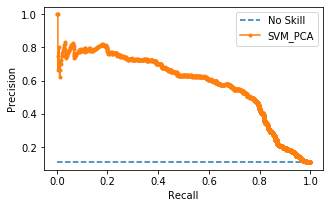

In [41]:
no_skill = len(test_y[test_y==1]) / len(test_y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='SVM_PCA')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [42]:
auprc3=auc(recall, precision)
auprc3

0.5860977319526934

In [43]:
table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUPRC'],
    'Score Linear Without PCA': [acc1, pre1, rec1, f1_1, auprc1],
    'Score RBF Without PCA': [acc2, pre2, rec2, f1_2, auprc2],
    'Score RBF With PCA (31)': [acc3, pre3, rec3, f1_3, auprc3]
    })
table

,Metric,Score Linear Without PCA,Score RBF Without PCA,Score RBF With PCA (31)
0,Accuracy,0.881282,0.900947,0.914300
1,Precision,0.455814,0.630303,0.658065
2,Recall,0.434590,0.230599,0.452328
3,F1 Score,0.444949,0.337662,0.536137
4,AUPRC,0.448848,0.582164,0.586098


## Tree-Based algoritmi

Stabla odluke često djeluju dobro na neuravnoteženim skupovima podataka jer im hijerarhijska struktura omogućuje učenje iz obje klase.

U modernom primijenjenom strojnom učenju ansambli stabala (Random Forests, Gradient Boosted Trees, itd.) gotovo uvijek nadmašuju pojedinačna stabla odlučivanja.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0)

Najjednostavniji način rješavanja problema neravnotežih klasa je korištenje klasifikatora koji je robusan prema neravnoteži klase. Najočitije je stablo odluka. Ako se rijetka klasa nalazi u određenom području obilježja ili barem to obično čini, većina ili sve rijetke klase leže u jednom čvoru stabla odlučivanja.

In [25]:
modelDTC = tree.DecisionTreeClassifier()
modelDTC = modelDTC.fit(X_train, y_train)
y_pred_tree = modelDTC.predict(X_test)
print('Decision Tree')
display_summary(y_test,y_pred_tree)

Decision Tree
confusion matrix
[[ 506  454]
 [ 461 6815]]
sensitivity is %f 0.5232678386763185
specificity is %f 0.9375429907827761
accuracy is %f 0.8889023797960175
balanced accuracy is % 0.7304054147295473


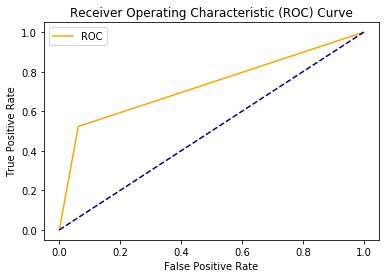

[[6815  454]
 [ 461  506]]
              precision    recall  f1-score   support

           0     0.9366    0.9375    0.9371      7269
           1     0.5271    0.5233    0.5252       967

    accuracy                         0.8889      8236
   macro avg     0.7319    0.7304    0.7311      8236
weighted avg     0.8886    0.8889    0.8887      8236



In [26]:
pred_tree_y = modelDTC.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_tree_y[:,1])
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred_tree))
print(classification_report(y_test,y_pred_tree,digits=4))

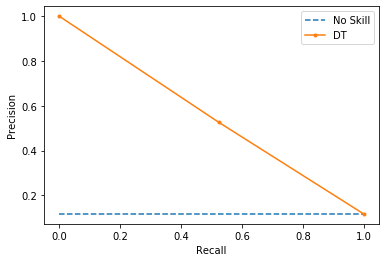

DT
confusion matrix
[[ 506  454]
 [ 461 6815]]
sensitivity is %f 0.5232678386763185
specificity is %f 0.9375429907827761
accuracy is %f 0.8889023797960175
balanced accuracy is % 0.7304054147295473
AUPRC: %f 0.5531624728430969


In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_tree_y[:,1])


no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='DT')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
print('DT')
display_summary(y_test,y_pred_tree)

auprc=auc(recall, precision)

print('AUPRC: %f',auprc)

## Slučajne šume

Slučajna šuma uključuje odabir bootstrap uzoraka iz skupa podataka za treniranje i postavljanje stabla odluke za svaki takav uzorak. Ne koriste se sve značajke (varijable ili stupci); umjesto toga, za svaki bootstrap uzorak odabran je mali nasumično odabrani podskup mogućnosti (stupaca).Kao posljedica, uklanja se korelacija stabala odluke (što ih čini neovisnijima), a zauzvrat, poboljšava se predviđanje ansambla.

[0 1]
0.9068722680913065
0.9163708616281149


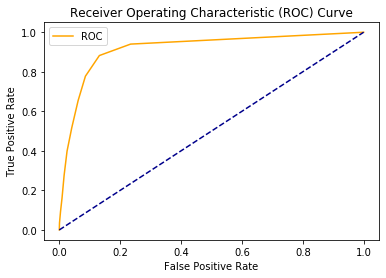

[[7084  185]
 [ 582  385]]
              precision    recall  f1-score   support

           0     0.9241    0.9745    0.9486      7269
           1     0.6754    0.3981    0.5010       967

    accuracy                         0.9069      8236
   macro avg     0.7998    0.6863    0.7248      8236
weighted avg     0.8949    0.9069    0.8961      8236



In [28]:
# Train model
modelRFC = RandomForestClassifier(n_estimators=10)
modelRFC.fit(X_train, y_train)
 
# Predict on test set
pred_y_RFC = modelRFC.predict(X_test)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_RFC ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y_test, pred_y_RFC) )

# What about AUROC?
prob_y_RFC = modelRFC.predict_proba(X_test)
prob_y_RFC = [p[1] for p in prob_y_RFC]
print( roc_auc_score(y_test, prob_y_RFC) )


fpr, tpr, thresholds = roc_curve(y_test, prob_y_RFC)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,pred_y_RFC))
print(classification_report(y_test,pred_y_RFC,digits=4))

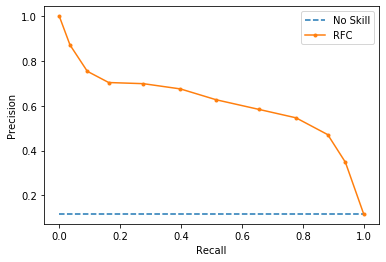

Random Forest
confusion matrix
[[ 385  185]
 [ 582 7084]]
sensitivity is %f 0.3981385729058945
specificity is %f 0.9745494565965057
accuracy is %f 0.9068722680913065
balanced accuracy is % 0.6863440147512001
AUPRC: %f 0.6151964721225514


In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, prob_y_RFC)

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RFC')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
print('Random Forest')
display_summary(y_test,pred_y_RFC)

auprc=auc(recall, precision)

print('AUPRC: %f',auprc)

In [30]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(modelRFC, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.908


### Ponderirane slučajne šume

Jednostavna tehnika za izmjenu stabla odlučivanja za neuravnoteženu klasifikaciju je promjena težine koju svaka klasa ima prilikom izračunavanja rezultata "nečistoća" odabrane točke razdvajanja.

Nečistoća mjeri koliko su skupine uzoraka pomiješane za određenu podjelu u skupu podataka za treniranje i obično se mjeri Ginijem ili entropijom. Budući da je RF klasifikator sklon pristrasnosti prema većinskoj klasi, dajemo strožu kaznu za pogrešno klasificiranje manjinske klase.

Ova modifikacija slučajne šume naziva se ponderiranom slučajnom šumom.

Mean ROC AUC: 0.910


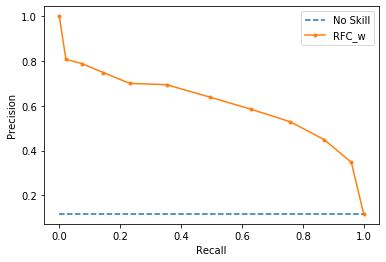

Random Forest
confusion matrix
[[ 341  150]
 [ 626 7119]]
sensitivity is %f 0.35263702171664946
specificity is %f 0.9793644242674371
accuracy is %f 0.9057795046138902
balanced accuracy is % 0.6660007229920433
AUPRC: %f 0.6117403865174496


In [31]:
modelRFC_w = RandomForestClassifier(n_estimators=10, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(modelRFC_w, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

modelRFC_w.fit(X_train, y_train)
pred_y_RFC_w = modelRFC_w.predict(X_test)
pred_y_RFC_w2 = modelRFC_w.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, pred_y_RFC_w2[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RFC_w')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
print('Random Forest')
display_summary(y_test,pred_y_RFC_w)

auprc=auc(recall, precision)

print('AUPRC: %f',auprc)

### Bootstrap ponderirane slučajne šume

S obzirom da je svako stablo odluka građeno iz bootstrap uzorka (npr. slučajni odabir sa ponavljanjem), distribucija klasa u uzorku podataka bit će različita za svako stablo.

Kao takva, moglo bi biti zanimljivo promijeniti ponderiranje klase na temelju distribucije klasa u svakom uzorku, umjesto čitavog skupa podataka za treniranje.

To se može postići postavljanjem argumenta class_weight na vrijednost 'balanced_subsample'.

Mean ROC AUC: 0.909


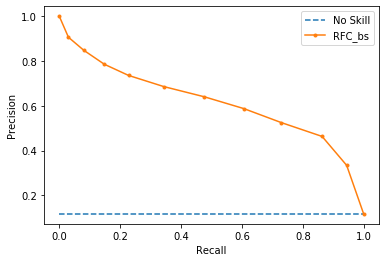

Random Forest
confusion matrix
[[ 332  152]
 [ 635 7117]]
sensitivity is %f 0.34332988624612204
specificity is %f 0.9790892832576695
accuracy is %f 0.9044439048081593
balanced accuracy is % 0.6612095847518957
AUPRC: %f 0.6184037706845286


In [32]:
modelRFC_bs = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(modelRFC_bs,  X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

modelRFC_bs.fit(X_train, y_train)
pred_y_RFC_bs = modelRFC_bs.predict(X_test)
pred_y_RFC_bs2 = modelRFC_bs.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, pred_y_RFC_bs2[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RFC_bs')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
print('Random Forest')
display_summary(y_test,pred_y_RFC_bs)

auprc=auc(recall, precision)

print('AUPRC: %f',auprc)

### Slučajne šume s nasumičnim podvlačenjem

Još jedna korisna izmjena slučajnih šuma je izvođenje ponovnog uzorkovanja podataka na bootstrap uzorku kako bi se izričito promijenila distribucija klasa.

Klasa BalancedRandomForestClassifier izvodi slučajno smanjivanje uzoraka većinske klase u bootstrap uzorku. 

Očekivali bismo da će to imati dramatičniji učinak na performanse modela s obzirom na širi uspjeh tehnika preraspodjele podataka.

In [34]:
from imblearn.ensemble import BalancedRandomForestClassifier
modelBRFC = BalancedRandomForestClassifier(n_estimators=10)

Mean ROC AUC: 0.932


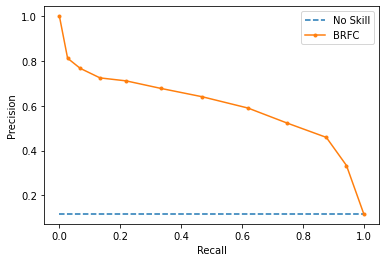

Random Forest
confusion matrix
[[ 322  153]
 [ 645 7116]]
sensitivity is %f 0.3329886246122027
specificity is %f 0.9789517127527858
accuracy is %f 0.9031083050024283
balanced accuracy is % 0.6559701686824942
AUPRC: %f 0.6024821717966081


In [45]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(modelBRFC, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

modelBRFC.fit(X_train, y_train)
pred_y_BRFC = modelRFC_w.predict(X_test)
pred_y_BRFC2 = modelRFC_w.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, pred_y_BRFC2[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='BRFC')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
print('Random Forest')
display_summary(y_test,pred_y_BRFC)

auprc=auc(recall, precision)

print('AUPRC: %f',auprc)

# XGBOOST

XGBoost je kraći zapis za Extreme Gradient Boosting i to je ansambl stabala gdje nova stabla ispravljaju pogreške onih stabala koja su već dio modela. Stabla se dodaju sve dok se daljnja poboljšanja ne mogu napraviti.

Također, to je stohastički algoritam za jačanje gradijenta, koji se naziva igradient boosting machines ili tree boosting, i snažna je tehnika strojnog učenja koja dobro ili čak najbolje funkcionira na širokom rasponu zahtjevnih problema strojnog učenja.

In [46]:
from xgboost import XGBClassifier

C:\Users\Petra\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Petra\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [47]:
modelXGB = XGBClassifier()
modelXGB.fit(X_train, y_train)

y_pred_XGB = modelXGB.predict(X_test)
predictions_XGB = [round(value) for value in y_pred_XGB]

accuracy_XGB = accuracy_score(y_test, predictions_XGB)
print("Accuracy: %.2f%%" % (accuracy_XGB * 100.0))

Accuracy: 91.17%


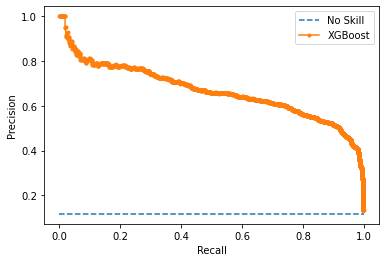

Random Forest
confusion matrix
[[ 501  261]
 [ 466 7008]]
sensitivity is %f 0.5180972078593589
specificity is %f 0.9640940982253405
accuracy is %f 0.9117289946576008
balanced accuracy is % 0.7410956530423497
AUPRC: %f 0.6670313600200964


In [48]:
y_proba_XGB = modelXGB.predict_proba(X_test) 
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_XGB[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGBoost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
print('Random Forest')
display_summary(y_test,y_pred_XGB)

auprc=auc(recall, precision)

print('AUPRC: %f',auprc)

In [49]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(modelXGB, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.94618


## Promjena funkcije troška

Možemo promijeniti ciljnu funkciju tako da uzmemo u obzir da trošak false pozitivnih i false negativnih vrijednosti ne može biti isti, a trošak oba može varirati ovisno o detaljima iz primjera. U našem slučaju, to bismo mogli objasniti ovako: cijena false pozitivnog može biti trošak vremena za pozivanje takvih korisnika, dok trošak false negativnog može biti gubitak korisnika koji bi ugovorio depozit, a zbog procjene ga se ne nazove.

Možemo promijeniti svoju ciljnu funkciju da to odražavamo. Na primjer, standardna funkcija gubitka logističke regresije je negativna log-likelihood funkcija 

$$ \sum_{i=1}^{N} [-y_i \log(h(X)^{(i)})) - (1-y_i)\log(1-h(X)^{(i)})), ] $$ gdje $ h(X)^{(i)} $ označava $ P(y = 1 | X^{(i)}) $.

Međutim, ako kažemo da svako opažanje ima neki true pozitivan $C_ {TP_i}$, true negativan $C_ {TN_i}$, false pozitivan $C_ {FP_i}$ i false negativan trošak $C_ {FN_i}$ povezan s njim, možemo koristiti sljedeću objektivnu funkciju:

$$ \frac{1}{N} \sum_{i=1}^{N} [ y_i \left(  \log(h(X)^{(i)})C_{TP_i} + (1-\log(h(X)^{(i)})C_{FN_i}) \right) + (1-y_i)\left( \log(h(X)^{(i)})C_{FP_i} + (1-\log(h(X)^{(i)})C_{TN_i}) \right)]. $$


### COSTCLA paket

In [36]:
import scipy
from costcla.metrics import cost_loss, savings_score
from costcla.models import CostSensitiveLogisticRegression, CostSensitiveDecisionTreeClassifier, CostSensitiveRandomForestClassifier

Postavljamo troškove true positive i true negative na  $0$. Za trošak false negativea uzimamo fiksnu vrijednost koja predstavlja gubitak profita zbog propusta mušterije. Cijenu false positivea računamo kao zbroj cijene poziva i plaće telefonskog. Konkretnije, računamo da je cijena poziva  $30$  eura po satu plus minimana plaća u Portugalu za  $2019$. godinu po satu. To množimo s brojem poziva te trajanjem zadnjeg poziva.

In [37]:
cost_mat_train = np.zeros((len(train_y),4))
cost_mat_train[:,0]=1
cost_mat_train[:,1]=1000
 
cost_mat_test = np.zeros((len(test_y),4))
cost_mat_test[:,0]=1
cost_mat_test[:,1]=1000

cost_mat_train_dtc = np.zeros((len(y_train),4))
cost_mat_train_dtc[:,0]=1
cost_mat_train_dtc[:,1]=1000
 
cost_mat_test_dtc = np.zeros((len(y_test),4))
cost_mat_test_dtc[:,0]=1
cost_mat_test_dtc[:,1]=1000

for i in range(len(train_y)):
    cost_mat_train[i,0] = ( 30+ 4.38 )* train_x["campaign"].values[i] *max(train_x["duration"].values[i],1)/3600.0
for i in range(len(y_train)):
    cost_mat_train_dtc[i,0] = (30+ 4.38) * X_train["campaign"].values[i] *max(X_train["duration"].values[i],1)/3600.0
for i in range(len(test_y)):
    cost_mat_test[i,0] = (30+ 4.38) * test_x["campaign"].values[i] *max(test_x["duration"].values[i],1)/3600.0
for i in range(len(y_test)):
    cost_mat_test_dtc[i,0] = (30 + 4.38) * X_test["campaign"].values[i]*max(X_test["duration"].values[i],1)/3600.0

In [38]:
g = CostSensitiveRandomForestClassifier()
g.fit(np.array(X_train), np.array(y_train), cost_mat_train_dtc)
y_pred_rf_cslr=g.predict(np.array(X_test))

In [39]:
h = CostSensitiveDecisionTreeClassifier()
h.fit(np.array(X_train), np.array(y_train), cost_mat_train_dtc)
y_pred_tree_cslr = h.predict(np.array(X_test))

In [40]:
print('naive: random forest')
print(cost_loss(y_test,pred_y_RFC,cost_mat_test_dtc))
print('naive: decision tree')
print(cost_loss(y_test,y_pred_tree,cost_mat_test_dtc))
print('random forest: cost sensitve learning')
print(cost_loss(y_test,y_pred_rf_cslr,cost_mat_test_dtc))
print('decision tree: cost sensitve learning')
print(cost_loss(y_test,y_pred_tree_cslr,cost_mat_test_dtc))

naive: random forest
584525.402
naive: decision tree
466392.99005
random forest: cost sensitve learning
36512.73465000001
decision tree: cost sensitve learning
35452.0257


In [44]:
f = CostSensitiveLogisticRegression()
f.fit(np.array(train_x),np.array(train_y), cost_mat_train)
y_pred_logistic_cslr = f.predict(test_x)

In [43]:
print('naive: logistic regression')
print(cost_loss(test_y,y_pred_logistic,cost_mat_test))

print('logistic: cost sensitve learning')
print(cost_loss(test_y,y_pred_logistic_cslr,cost_mat_test))

naive: logistic regression
265492.99925
logistic: cost sensitve learning
19366.330800000003
